# Mossy fibre short term plasticity during burst spike patterns

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [17]:
scale_dist_x = 0.04
scale_dist_y = 0.04
graph_width = 6.0
graph_height = 4.0
key_dist = 0.04

def plot_scalebars(ax, div=3.0, labels=True,
                   xunits="", yunits="", nox=False,
                   sb_xoff=0, sb_yoff=0,
                   sb_ylabel_xoff_comp=False, sb_ylabel_yoff=0,
                   rotate_yslabel=False,
                   linestyle="-k", linewidth=4.0,
                   textcolor='k', textweight='normal',
                   xmin=None, xmax=None, ymin=None, ymax=None):

    # print dir(ax.dataLim)
    if xmin is None:
        xmin = ax.dataLim.xmin
    if xmax is None:
        xmax = ax.dataLim.xmax
    if ymin is None:
        ymin = ax.dataLim.ymin
    if ymax is None:
        ymax = ax.dataLim.ymax
    xscale = xmax-xmin
    yscale = ymax-ymin

    xoff = (scale_dist_x + sb_xoff) * xscale
    if sb_ylabel_xoff_comp:
        xoff_ylabel = scale_dist_x * xscale
    else:
        xoff_ylabel = xoff

    yoff = (scale_dist_y - sb_yoff) * yscale

    # plot scale bars:
    xlength = prettyNumber((xmax-xmin)/div)
    xend_x, xend_y = xmax, ymin
    if not nox:
        xstart_x, xstart_y = xmax-xlength, ymin
        scalebarsx = [xstart_x+xoff, xend_x+xoff]
        scalebarsy = [xstart_y-yoff, xend_y-yoff]
    else:
        scalebarsx = [xend_x+xoff, ]
        scalebarsy = [xend_y-yoff]

    ylength = prettyNumber((ymax-ymin)/div)
    yend_x, yend_y = xmax, ymin+ylength
    scalebarsx.append(yend_x+xoff)
    scalebarsy.append(yend_y-yoff)

    ax.plot(scalebarsx, scalebarsy, linestyle, linewidth=linewidth,
            solid_joinstyle='miter')

    if labels:
        # if textcolor is not None:
        #     color = "\color{%s}" % textcolor
        # else:
        #     color = ""
        if not nox:
            # xlabel
            if xlength >= 1:
                xlabel = r"%d$\,$%s" % (xlength, xunits)
            else:
                xlabel = r"%g$\,$%s" % (xlength, xunits)
            xlabel_x, xlabel_y = xmax-xlength/2.0, ymin
            xlabel_y -= key_dist*yscale
            ax.text(
                xlabel_x+xoff, xlabel_y-yoff, xlabel, ha='center', va='top',
                weight=textweight, color=textcolor)
        # ylabel
        if ylength >= 1:
            ylabel = r"%d$\,$%s" % (ylength, yunits)
        else:
            ylabel = r"%g$\,$%s" % (ylength, yunits)
        if not rotate_yslabel:
            ylabel_x, ylabel_y = \
                xmax, ymin + ylength/2.0 + sb_ylabel_yoff*yscale
            ylabel_x += key_dist*xscale
            ax.text(ylabel_x+xoff_ylabel, ylabel_y-yoff, ylabel,
                    ha='left', va='center',
                    weight=textweight, color=textcolor)
        else:
            ylabel_x, ylabel_y = xmax, ymin + ylength/2.0 + sb_ylabel_yoff
            ylabel_x += key_dist*xscale
            ax.text(ylabel_x+xoff_ylabel, ylabel_y-yoff, ylabel,
                    ha='left', va='center', rotation=90,
                    weight=textweight, color=textcolor)
            
def prettyNumber(f):
    fScaled = f
    if fScaled < 1:
        correct = 10.0
    else:
        correct = 1.0

    # set stepsize
    try:
        nZeros = int(np.log10(fScaled))
    except OverflowError:
        nZeros = 0

    prev10e = 10.0**nZeros / correct
    next10e = prev10e * 10

    if fScaled / prev10e > 7.5:
        return next10e
    elif fScaled / prev10e > 5.0:
        return 5 * prev10e
    else:
        return round(fScaled/prev10e) * prev10e

In [6]:
fast_isi = np.logspace(-2,0,100)
slow_isi = np.logspace(0,2,100)
F,S = np.meshgrid(fast_isi,slow_isi)

In [7]:
tauf_e = 3.3; f0_e = 0.3; a_e = 0.15

finf = (f0_e*np.exp(S/tauf_e)-f0_e+a_e)/(np.exp(S/tauf_e)-1+a_e)

E0 = finf

def fac2(Eprev,finf,a,tauf,ISI):
    Enew = finf - (finf - Eprev - a*(1-Eprev))*np.exp(-ISI/tauf)
    return Enew

def EPSC_train(tauf, f0, a, S, F, n=9):
    f_inf = (f0*np.exp(S/tauf)-f0+a)/(np.exp(S/tauf)-1+a)
    E = [f_inf]
    for i in range(n):
        f_new = fac2(E[-1], f_inf, a, tauf, F)
        E.append(f_new)
    return np.array(E)**2

E = [E0]

for i in range(9):
    E.append(fac2(E[-1],finf=finf,a=a_e,tauf=tauf_e,ISI=F))
    
E = np.array(E)**2

In [8]:
tauf_i = 1.4;taud_i = 0.8;taua_i = 8.0; f0_i = 0.05; f0_ic= 0.16; a0_i = 0.08; b_i = 0.11;

def IPSC_train(tauf,taud,taua,f0,a0,b,S,F,n=9):
    ainf = (a0*np.exp(S/taua) - a0 + b)/(np.exp(S/taua)-1+b)
    finf = (f0*np.exp(S/tauf) - f0 + ainf)/(np.exp(S/tauf)-1+ainf)
    dinf = (1-np.exp(-S/taud))/(1+(1-finf)*np.exp(-S/taud))

    a1 = ainf + b_i*(1-ainf)*np.exp(-F/taua)
    f1 = finf + a0_i*(1-finf)/np.exp(-F/tauf)
    d1 = dinf - (dinf*finf)*np.exp(-F/taud)
    
    A =[ainf];P=[finf];D=[dinf]
    for i in range(n):
        anew,fnew,dnew = afd(aprev=A[-1],fprev=P[-1],dprev=D[-1],
                             ainf=ainf,finf=finf,dinf=dinf,
                             b=b_i,tauf=tauf_i,taud=taud_i,taua=taua_i,ISI=F)
        A.append(anew); P.append(fnew);D.append(dnew)
        
    A = np.array(A); P = np.array(P); D = np.array(D)
    
    return P*D

def afd(aprev,fprev,dprev,b,ainf,finf,dinf,tauf,taud,taua,ISI):
    anew = ainf - (ainf - aprev - b*(1-aprev))*np.exp(-ISI/taua)
    fnew = finf - (finf - fprev - aprev*(1-fprev))*np.exp(-ISI/tauf)
    dnew = dinf - (dinf - dprev + dprev*fprev)*np.exp(-ISI/taud)
    return anew,fnew,dnew

I = IPSC_train(tauf_i,taud_i,taua_i,f0_i,a0_i,b_i,S,F)
Ic= IPSC_train(tauf_i,taud_i,taua_i,f0_ic,a0_i,b_i,S,F)

In [9]:
def remove_upper_right_ticks(ax):
    '''Remove and lines from upper and right edges of figure'''
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


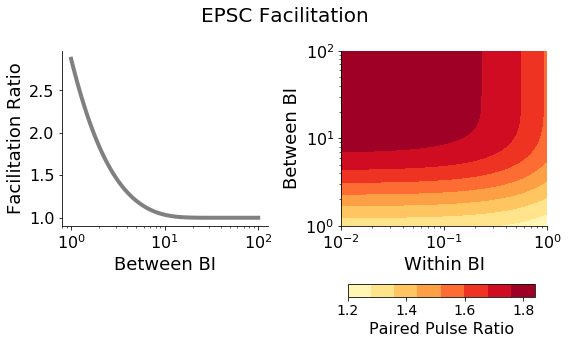

In [10]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(8,3.5))

C1 = axs[1].contourf(F,S,E[1]/E[0],cmap=cm.YlOrRd)
C1.ax.set_xscale('log')
C1.ax.set_yscale('log')

C1.ax.tick_params(axis='both',labelsize=16)
cax = fig.add_axes([0.61,-0.05,0.325,0.05])
fig.colorbar(C1,cax=cax,label='Paired Pulse Ratio',orientation='horizontal',ticks=[1.2,1.4,1.6,1.8])
cax.set_xticklabels([1.2,1.4,1.6,1.8],fontsize=14)
cax.set_xlabel(cax.get_xlabel(),fontsize=16)

axs[1].set_xlabel('Within BI',size=18)
axs[1].set_ylabel('Between BI',size=18)

axs[0].semilogx(S[:,0],E[0,:,0]/f0_e**2,lw=4,color='grey')
axs[0].tick_params(axis='both',labelsize=16)
axs[0].set_ylabel('Facilitation Ratio',size=18)
axs[0].set_xlabel('Between BI',size=18)

for ax in axs:
    remove_upper_right_ticks(ax)

fig.suptitle('EPSC Facilitation',size=20,x=0.5,y=1.10,)
fig.tight_layout()

# fig.savefig('./reworked_figs/mf-stp-burst-epsc.svg')

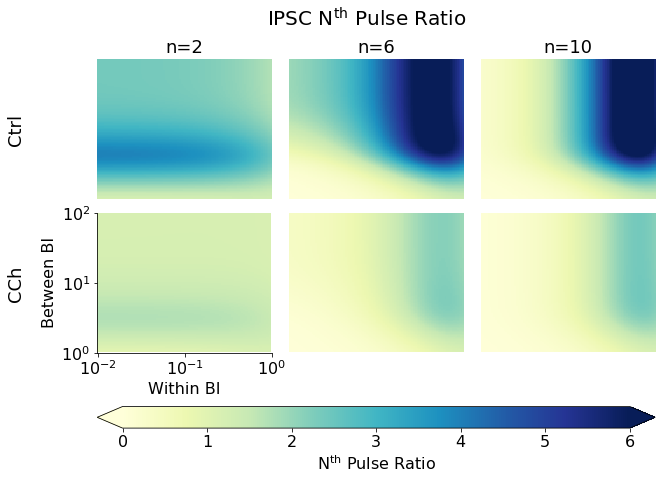

In [11]:
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(10,6))

cmap=cm.YlGnBu

def plot_ppr_img(ax,Z,cmap=cmap):
    im = ax.imshow(np.flipud(Z),cmap=cmap,vmin=0,vmax=6,interpolation='nearest',aspect='auto')
    ax.axis('off')
    return im

plot_ppr_img(axs[0,0],I[1]/I[0])
plot_ppr_img(axs[0,1],I[5]/I[0])
plot_ppr_img(axs[0,2],I[9]/I[0])

plot_ppr_img(axs[1,0],Ic[1]/Ic[0])
plot_ppr_img(axs[1,1],Ic[5]/Ic[0])
im = plot_ppr_img(axs[1,2],Ic[9]/Ic[0])

axs[0,0].set_title('n=2',fontsize=18)
axs[0,1].set_title('n=6',fontsize=18)
axs[0,2].set_title('n=10',fontsize=18)

fig.subplots_adjust(bottom=0.2,wspace=0.1,hspace=0.1)
cax = fig.add_axes([0.125,0.025,0.775,0.05])
fig.colorbar(im,cax=cax,extend='both',orientation='horizontal',label='N$^\mathrm{th}$ Pulse Ratio')

cax.tick_params(labelsize=16)
cax.set_xlabel(cax.get_xlabel(),fontsize=16)
axs[1,0].axis('on')
remove_upper_right_ticks(axs[1,0])

plt.sca(axs[1,0])
plt.xticks([0,50,100],[r'10$^{-2}$',r'10$^{-1}$',r'10${^0}$'],fontsize=16)
plt.yticks([0,50,100],[r'10$^{2}$',r'10$^{1}$',r'10${^0}$'],fontsize=16)
plt.xlabel('Within BI',fontsize=16)
plt.ylabel('Between BI',fontsize=16)

fig.suptitle('IPSC N$^\mathrm{th}$ Pulse Ratio',fontsize=20,x=0.5,y=1)

fig.text(0,0.37,'CCh',rotation=90,fontsize=18)
fig.text(0,0.72,'Ctrl',rotation=90,fontsize=18)

fig.savefig('./reworked_figs/mf-stp-burst-ipsc.svg')

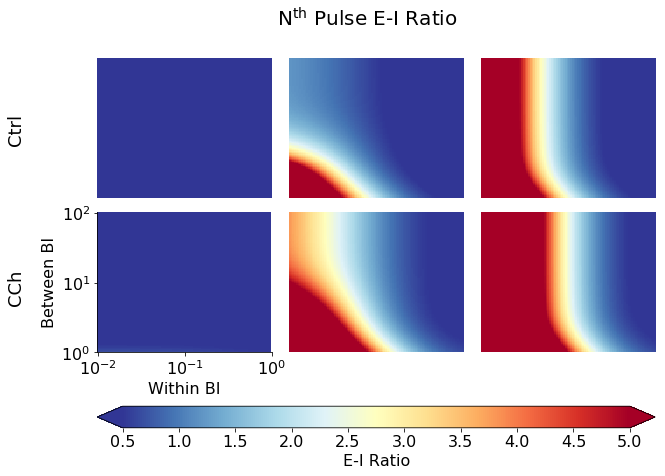

In [12]:
fig,axs=plt.subplots(nrows=2,ncols=3,figsize=(10,6))

cmap = cm.RdYlBu_r

def plot_ei_img(ax,Z,cmap=cmap):
    im = ax.imshow(np.flipud(Z),cmap=cmap,vmin=0.5,vmax=5,aspect='auto')
    ax.axis('off')
    return im

ge=6.6
gi=26.
gei = ge/gi

plot_ei_img(axs[0,0],gei*E[1]/I[1])
plot_ei_img(axs[0,1],gei*E[5]/I[5])
plot_ei_img(axs[0,2],gei*E[9]/I[9])

ge=3.3
gi=6.7
gei = ge/gi

plot_ei_img(axs[1,0],gei*E[1]/Ic[1])
plot_ei_img(axs[1,1],gei*E[5]/Ic[5])
im = plot_ei_img(axs[1,2],gei*E[9]/Ic[9])

fig.subplots_adjust(bottom=0.2,wspace=0.1,hspace=0.1)
cax = fig.add_axes([0.125,0.025,0.775,0.05])
fig.colorbar(im,cax=cax,extend='both',orientation='horizontal',label='E-I Ratio')

cax.tick_params(labelsize=16)
cax.set_xlabel(cax.get_xlabel(),fontsize=16)

fig.suptitle('N$^\mathrm{th}$ Pulse E-I Ratio',fontsize=20,x=0.5,y=1.)
axs[1,0].axis('on')
remove_upper_right_ticks(axs[1,0])

plt.sca(axs[1,0])
plt.xticks([0,50,100],[r'10$^{-2}$',r'10$^{-1}$',r'10${^0}$'],fontsize=16)
plt.yticks([0,50,100],[r'10$^{2}$',r'10$^{1}$',r'10${^0}$'],fontsize=16)
plt.xlabel('Within BI',fontsize=16)
plt.ylabel('Between BI',fontsize=16)

fig.text(0,0.36,'CCh',rotation=90,fontsize=18)
fig.text(0,0.72,'Ctrl',rotation=90,fontsize=18)

fig.savefig('./reworked_figs/mf-stp-burst-eiratio.svg')

In [13]:
'''
MF-EPSC parameters
'''

p0_e = 0.3
taup_e = 3.3
a_e = 0.15

g_ectr = 6.6
g_ecch = 3.3

'''
MF-IPSC parameters
'''
taup_ictr = 1.4
tauq_ictr = 0.8
taua_ictr = 8.0
p0_ictr = 0.05
a0_ictr = 0.08
b_ictr = 0.11

taup_icch = 1.4
tauq_icch = 0.8
taua_icch = 8.0
p0_icch = 0.16
a0_icch = 0.08
b_icch = 0.11

g_ictr = 26.0
g_icch = 6.7

'''
Within and between burst intervals
'''

w1_burst = 0.02
b1_burst = 2.00

w2_burst = 0.02
b2_burst = 50.0

w3_burst = 0.5
b3_burst = 50.0

t  = np.linspace(0,20,1000)

EPSC = np.clip(((t-1.0)/1.0)*np.exp(1-((t-1.0)/1.0)),0,np.inf)
IPSC = np.clip(((t-4.0)/4.0)*np.exp(1-((t-4.0)/4.0)),0,np.inf)

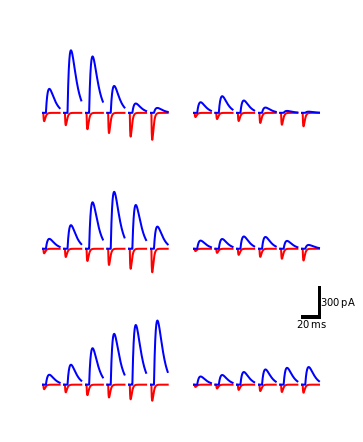

In [22]:
fig,axs = plt.subplots(nrows=3,ncols=13,figsize=(5,7.5),sharex=True,sharey=True)

for ix,(wint,bint) in enumerate([[w1_burst,b1_burst],[w2_burst,b2_burst],[w3_burst,b3_burst]]):
    
    peinf = (p0_e*np.exp(bint/taup_e) - p0_e + a_e)/(np.exp(bint/taup_e)-1+a_e)
    
    ainf = (a0_ictr*np.exp(bint/taua_ictr) - a0_ictr + b_ictr)/(np.exp(bint/taua_ictr)-1+b_ictr)
    piinf = (p0_ictr*np.exp(bint/taup_ictr) - p0_ictr + ainf)/(np.exp(bint/taup_ictr)-1+ainf)
    qinf = (1-np.exp(-bint/tauq_ictr))/(1+(1-piinf)*np.exp(-bint/tauq_ictr))
    
    axs[ix][0].plot(t,EPSC*peinf**2*g_ectr*-80,'r',lw=2)
    axs[ix][0].plot(t,IPSC*piinf*qinf*g_ictr*80,'b',lw=2)
    
    axs[ix][0].axis('off')
    
    peprev = peinf
    
    aprev = ainf
    piprev = piinf
    qprev = qinf
    
    for jx in xrange(5):
        peinc = peprev +a_e*(1-peprev)
        penext = peinf - (peinf - peinc)*np.exp(-wint/taup_e)
        peprev = penext
        axs[ix][jx+1].plot(t,EPSC*penext**2*g_ectr*-80,'r',lw=2)
        
        ainc = aprev + b_ictr*(1-aprev)
        piinc = piprev +aprev*(1-piprev)
        qinc = qprev - piprev*qprev
        anext = ainf - (ainf - ainc)*np.exp(-wint/taua_ictr)
        pinext = piinf - (piinf - piinc)*np.exp(-wint/taup_ictr)
        qnext = qinf - (qinf-qinc)*np.exp(-wint/tauq_ictr)
        aprev = anext
        piprev = pinext
        qprev = qnext
        axs[ix][jx+1].plot(t,IPSC*pinext*qnext*g_ictr*80,'b',lw=2)
        
        axs[ix][jx+1].axis('off')
        
for ix,(wint,bint) in enumerate([[w1_burst,b1_burst],[w2_burst,b2_burst],[w3_burst,b3_burst]]):
    
    peinf = (p0_e*np.exp(bint/taup_e) - p0_e + a_e)/(np.exp(bint/taup_e)-1+a_e)
    
    ainf = (a0_icch*np.exp(bint/taua_icch) - a0_icch + b_icch)/(np.exp(bint/taua_icch)-1+b_icch)
    piinf = (p0_icch*np.exp(bint/taup_icch) - p0_icch + ainf)/(np.exp(bint/taup_icch)-1+ainf)
    qinf = (1-np.exp(-bint/tauq_icch))/(1+(1-piinf)*np.exp(-bint/tauq_icch))
    
    axs[ix][7].plot(t,EPSC*peinf**2*g_ecch*-80,'r',lw=2)
    axs[ix][7].plot(t,IPSC*piinf*qinf*g_icch*80,'b',lw=2)
    
    axs[ix][7].axis('off')
    axs[ix][6].axis('off')
    
    peprev = peinf
    
    aprev = ainf
    piprev = piinf
    qprev = qinf
    
    for jx in xrange(5):
        peinc = peprev +a_e*(1-peprev)
        penext = peinf - (peinf - peinc)*np.exp(-wint/taup_e)
        peprev = penext
        axs[ix][jx+8].plot(t,EPSC*penext**2*g_ecch*-80,'r',lw=2)
        
        ainc = aprev + b_icch*(1-aprev)
        piinc = piprev +aprev*(1-piprev)
        qinc = qprev - piprev*qprev
        anext = ainf - (ainf - ainc)*np.exp(-wint/taua_icch)
        pinext = piinf - (piinf - piinc)*np.exp(-wint/taup_icch)
        qnext = qinf - (qinf-qinc)*np.exp(-wint/tauq_icch)
        aprev = anext
        piprev = pinext
        qprev = qnext
        axs[ix][jx+8].plot(t,IPSC*pinext*qnext*g_icch*80,'b',lw=2)
        
        axs[ix][jx+8].axis('off')
        ax = axs[ix][jx+8]

plot_scalebars(ax,xunits='ms',yunits='pA',div=1.0,sb_yoff=3.0)

fig.subplots_adjust(wspace=0.1,hspace=0.0)

fig.savefig('./reworked_figs/mf-ach-ei-example.svg')

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

epsc = np.loadtxt('./fig3_data/epsc_maps_norm.csv', delimiter=',', skiprows=1).T
ipsc = np.loadtxt('./fig3_data/ipsc_maps_norm.csv', delimiter=',', skiprows=1).T

In [3]:
epsc_cch_changes = epsc[1:, epsc[0].astype('bool')].T

In [4]:
ipsc_cch_changes = ipsc[1:, ipsc[0].astype('bool')].T

In [5]:
ipsc_base = np.array([26.0, 1.4, 0.8, 8.0, 0.05, 0.08, 0.11])

taup_ictr = 1.4
tauq_ictr = 0.8
taua_ictr = 8.0
p0_ictr = 0.05
a0_ictr = 0.08
b_ictr = 0.11

epsc_base = np.array([6.6, 3.3, 0.3, 0.15])

epsc_base*epsc_cch_changes[0]

array([2.44051447, 7.23033708, 0.27410714, 0.15122951])

In [6]:
def fac2(Eprev,finf,a,tauf,ISI):
    Enew = finf - (finf - Eprev - a*(1-Eprev))*np.exp(-ISI/tauf)
    return Enew

def afd(aprev,fprev,dprev,b,ainf,finf,dinf,tauf,taud,taua,ISI):
    anew = ainf - (ainf - aprev - b*(1-aprev))*np.exp(-ISI/taua)
    fnew = finf - (finf - fprev - aprev*(1-fprev))*np.exp(-ISI/tauf)
    dnew = dinf - (dinf - dprev + dprev*fprev)*np.exp(-ISI/taud)
    return anew,fnew,dnew

def EPSC_train(tauf, f0, a, S, F, n=9):
    f_inf = (f0*np.exp(S/tauf)-f0+a)/(np.exp(S/tauf)-1+a)
    E = [f_inf]
    for i in range(n):
        f_new = fac2(E[-1], f_inf, a, tauf, F)
        E.append(f_new)
    return np.array(E)**2

def IPSC_train(tauf,taud,taua,f0,a0,b,S,F,n=9):
    ainf = (a0*np.exp(S/taua) - a0 + b)/(np.exp(S/taua)-1+b)
    finf = (f0*np.exp(S/tauf) - f0 + ainf)/(np.exp(S/tauf)-1+ainf)
    dinf = (1-np.exp(-S/taud))/(1+(1-finf)*np.exp(-S/taud))

    a1 = ainf + b*(1-ainf)*np.exp(-F/taua)
    f1 = finf + a0*(1-finf)/np.exp(-F/tauf)
    d1 = dinf - (dinf*finf)*np.exp(-F/taud)
    
    A =[ainf];P=[finf];D=[dinf]
    for i in range(n):
        anew,fnew,dnew = afd(aprev=A[-1],fprev=P[-1],dprev=D[-1],
                             ainf=ainf,finf=finf,dinf=dinf,
                             b=b,tauf=tauf,taud=taud,taua=taua,ISI=F)
        A.append(anew); P.append(fnew);D.append(dnew)
        
    A = np.array(A); P = np.array(P); D = np.array(D)
    
    return P*D

def EI_ratio(e_params, i_params, S, F, n=9):
    g_e, tauf_e, f0_e, a_e = e_params
    g_i, tauf_i, taud_i, taua_i, f0_i, a0_i, b_i = i_params
    
    E = g_e * EPSC_train(tauf_e, f0_e, a_e, S, F, n)
    I = g_i * IPSC_train(tauf_i, taud_i, taua_i, f0_i, a0_i, b_i, S, F, n)
    return E/I

In [7]:
result = []

for i in range(len(epsc_cch_changes)):
    for j in range(len(ipsc_cch_changes)):
        result.append(EI_ratio(e_params=epsc_base*epsc_cch_changes[i], i_params=ipsc_base*ipsc_cch_changes[j], S=np.array([2.0, 10.0, 50.0, 50.0]), F=np.array([0.02, 0.05, 0.02, 0.5])))

In [9]:
result = np.array(result)

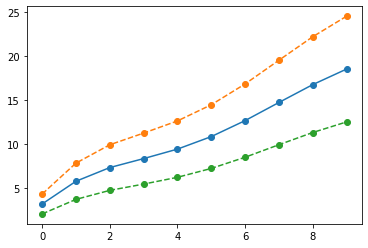

In [18]:
i = 1

mean_ei_ratio = np.mean(result[:, :, i], axis=0)
sem_ei_ratio = np.sqrt((np.mean(result[:, :, i]**2, axis=0) - mean_ei_ratio**2)/len(result))

plt.plot(mean_ei_ratio, '-o')
plt.plot(mean_ei_ratio+sem_ei_ratio, '--o')
plt.plot(mean_ei_ratio-sem_ei_ratio, '--o')

Text(0.5, 1.0, 'Comparison of E-I ratio model to data \n for 20 Hz bursts delivered every 20 seconds')

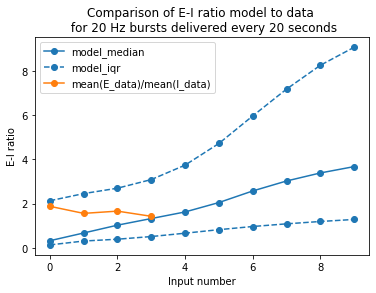

In [57]:
i = 1
plt.plot(np.median(result[:, :, i], axis=0), '-o', color='C0', label='model_median');
plt.plot(np.percentile(result[:, :, i], q=75, axis=0), '--o', color='C0', label='model_iqr')
plt.plot(np.percentile(result[:, :, i], q=25, axis=0), '--o', color='C0')

plt.plot(abs(np.mean(e_data, axis=0))/np.mean(i_data, axis=0), '-o', color='C1', label='mean(E_data)/mean(I_data)')
plt.legend()

plt.ylabel('E-I ratio')
plt.xlabel('Input number')
plt.title('Comparison of E-I ratio model to data \n for 20 Hz bursts delivered every 20 seconds')

In [135]:
ipsc_cch_changes.mean(axis=0)

array([0.26940126, 1.78492765, 0.38425298, 0.55253842, 3.25663301,
       0.43388366, 0.34061532])

In [33]:
result_2 = EI_ratio(e_params=epsc_base*np.median(epsc_cch_changes, axis=0), i_params=ipsc_base*np.median(ipsc_cch_changes, axis=0), S=np.array([2.0, 10.0, 50.0, 50.0]), F=np.array([0.02, 0.05, 0.02, 0.5]))

In [34]:
e_data

array([[ -58.3846185 , -113.2405914 , -207.41781556, -203.41158407],
       [  -8.57070097,  -51.99270655,  -89.55758009,  -68.4273424 ],
       [ -14.52141601,  -33.32172458,  -50.32203814,  -94.6115735 ],
       [ -41.48650962, -121.22805141, -182.87058495, -185.88465362],
       [ -79.99079482, -124.44918938, -152.18005848, -181.01072705],
       [-104.99036002,  -99.88320621, -170.10129642, -291.46433743],
       [ -62.13128706, -106.61510413, -172.58374217, -267.02793712]])

[]

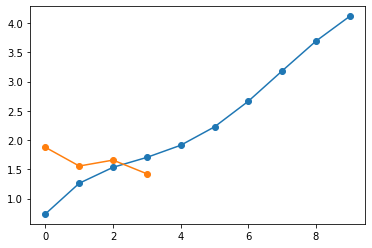

In [38]:
plt.plot(result_2[:, 1], '-o')
plt.plot(abs(np.mean(e_data, axis=0))/np.mean(i_data, axis=0), '-o')

plt.plot()

# plt.plot(np.median(np.array(result_data), axis=0), '-o')

In [22]:
e_data = np.loadtxt('./fig1_data/epsc_amps.csv', delimiter=',', skiprows=1)[:, 4:]

In [23]:
i_data = np.loadtxt('./fig1_data/ipsc_amps.csv', delimiter=',', skiprows=1)[:, 4:]

In [24]:
result_data = []
for i in range(len(e_data)):
    for j in range(len(i_data)):
        result_data.append(abs(e_data[i])/i_data[j])

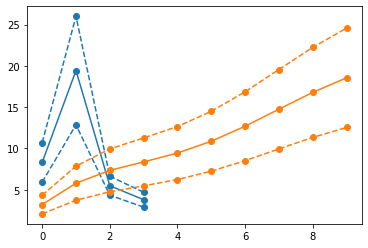

In [48]:
mean_data = np.mean(result_data, axis=0)
sem_data = np.sqrt(np.var(result_data, axis=0)/len(result_data))

plt.plot(mean_data, '-o', color='C0')
plt.plot(mean_data+sem_data, '--o', color='C0')
plt.plot(mean_data-sem_data, '--o', color='C0')

i = 1

mean_ei_ratio = np.mean(result[:, :, i], axis=0)
sem_ei_ratio = np.sqrt((np.mean(result[:, :, i]**2, axis=0) - mean_ei_ratio**2)/len(result))

plt.plot(mean_ei_ratio, '-o', color='C1')
plt.plot(mean_ei_ratio+sem_ei_ratio, '--o', color='C1')
plt.plot(mean_ei_ratio-sem_ei_ratio, '--o', color='C1')